# Stackoverflow EDA

## 1.0 Introduction
This project aims to conduct an exploratory data analysis (EDA) on the StackOverflow public data available on BigQuery, with a focus on the Python community. StackOverflow is a well-known online platform for developers to ask and answer questions related to programming, with the Python language having a significant presence on the site. The data on BigQuery provides a wealth of information, including users, questions, answers, and tags, which can be used to gain insights into the Python community on StackOverflow. By performing an EDA on this data, patterns, trends, and relationships between different variables can be uncovered, providing valuable insights into the Python community and the wider software development landscape using Python.

### 1.1 Objectives:

Understanding community engagement:
- Posts volume by day of the week and month over month
- Monthly Active User (MAU) metric
- Percentage of question posts that received an answer or comment within 1 day
- Impact of views on answers and comments

Understanding posts and user attributes:
- Effect of post attributes on other values
- Correlations between different user attributes (e.g., tenure vs reputation vs votes count)

Understanding sub-groups of Python users through tags associated with each post:
- Community detection through tags
- Mapping and relationships between communities

### 1.2 Scope and Expectations

The scope of this analysis is limited to the data from 2021, due to Google's quota limitations and availability of the most recent and complete data for that year. 2022 data is not complete, and 2020 data may be unreliable due to the ongoing pandemic. The focus is solely on the Python community on StackOverflow, as this is the area I am interested in.

# 2.0 Setup

Import all neccessary modules to be use in this project and setup connection between Jupyter Notebook with BigQuery.

In [1]:
import pandas as pd
import numpy as np
import itertools
from IPython.display import Image
import datetime

from google.cloud import bigquery
import glob

import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
from pyvis.network import Network
from community import community_louvain

%matplotlib inline

In [2]:
# setup oauth/credential and client connection
# the api key will be excluded from commit in gitignore file. 
credential_path = glob.glob(r'../api_key/*.json')
client = bigquery.Client.from_service_account_json(credential_path[0])

## 2.1 Define Helpers Functions

Create functions to make retrieve data using SQL queries and request table schema information.

In [3]:
def get_query_as_df(query):
    '''
    Description: This function takes a query as input and returns the results of that query in the form of a Pandas DataFrame. The function executes the query using a client object and then converts the results to a DataFrame using the to_dataframe() method.

    Parameters:
    
    - query: a string that represents the SQL query to execute
    
    Returns:
    
    - A Pandas DataFrame that contains the results of the query
    
    Example usage:
    
    query = "SELECT * FROM my_table"
    df = get_query_as_df(query)
    print(df.head())
    '''
    return client.query(query).result().to_dataframe()

def get_table_schema(table):
    '''
    Description: This function takes a table name as input and returns the schema of that table. The function retrieves the schema of the table using a client object and returns it.

    Parameters:

    - table: a string that represents the name of the table whose schema is to be retrieved
    
    Returns:

    - A list of objects, where each objects contains information about a column in the table. Each object has the following keys:
        - name: the name of the column
        - type: the data type of the column
        - mode: the mode of the column (e.g. "NULLABLE" or "REQUIRED")
        - description: a description of the column (if available)
    
    Example usage:
    
    table_name = "my_table"
    schema = get_table_schema(table_name)
    '''
    return client.get_table(table).schema

## 3.0 EDA

To reiterate on the project objectives:
- Users engagement rate such as number of posts based on day of the weerk and month over month. 
- Insight into percentage of posts received a comment or an answer within 1 day of posting.
- Explore relationship of views count impact on number of answers and comments. 
- Insight into Month Active Users rate on the platform month over month.
- Uncover relationship between users' attributess such as tenure, post count, views, reputation, etc...
- Sub-groups within the Python communities and their relationship to each other.

### 3.1 Posts and Community Metrics

In [5]:
# request posts_questions table schema
schema = get_table_schema('bigquery-public-data.stackoverflow.posts_questions')
schema

[SchemaField('id', 'INTEGER', 'NULLABLE', None, None, (), None),
 SchemaField('title', 'STRING', 'NULLABLE', None, None, (), None),
 SchemaField('body', 'STRING', 'NULLABLE', None, None, (), None),
 SchemaField('accepted_answer_id', 'INTEGER', 'NULLABLE', None, None, (), None),
 SchemaField('answer_count', 'INTEGER', 'NULLABLE', None, None, (), None),
 SchemaField('comment_count', 'INTEGER', 'NULLABLE', None, None, (), None),
 SchemaField('community_owned_date', 'TIMESTAMP', 'NULLABLE', None, None, (), None),
 SchemaField('creation_date', 'TIMESTAMP', 'NULLABLE', None, None, (), None),
 SchemaField('favorite_count', 'INTEGER', 'NULLABLE', None, None, (), None),
 SchemaField('last_activity_date', 'TIMESTAMP', 'NULLABLE', None, None, (), None),
 SchemaField('last_edit_date', 'TIMESTAMP', 'NULLABLE', None, None, (), None),
 SchemaField('last_editor_display_name', 'STRING', 'NULLABLE', None, None, (), None),
 SchemaField('last_editor_user_id', 'INTEGER', 'NULLABLE', None, None, (), None),


In [6]:
# pull all python questions posts in 2021
query = """
        SELECT 
            extract(month from creation_date) as month,
            extract(dayofweek from creation_date) as day_of_week,
            id
        FROM `bigquery-public-data.stackoverflow.posts_questions`
        WHERE 
            extract(year from creation_date) = 2021
            and tags like '%python%'
        """

posts_questions = get_query_as_df(query)
posts_questions.sample(10)

,month,day_of_week,id
135187,11,4,70005305
226583,11,6,69940591
2519,6,1,68149020
115636,4,3,66975072
12388,5,1,67561498
46963,5,2,67362718
57661,5,2,67671309
114156,3,3,66433478
128975,9,4,69370488
118584,3,3,66766371


Let take a look at day of the week and MoM volume to see which are busiest.

Text(0.5, 0.98, 'Weekday vs MoM Post Volume')

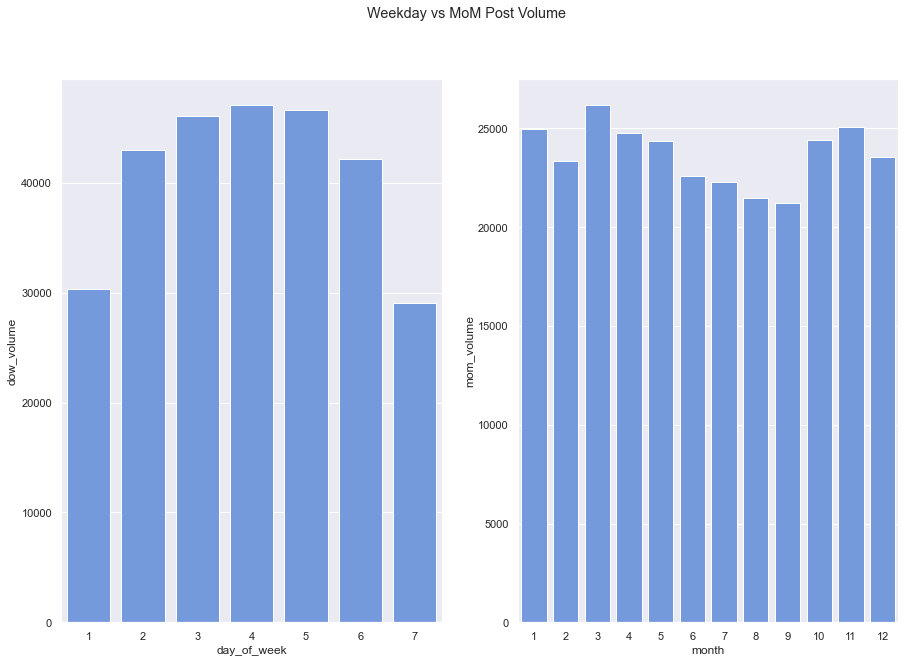

In [7]:
num_q_month = posts_questions.groupby('month')['id'].nunique().rename('mom_volume').reset_index()
num_q_week = posts_questions.groupby('day_of_week')['id'].nunique().rename('dow_volume').reset_index()

sns.set(rc={'figure.figsize':(15,10)})
fig,ax = plt.subplots(1,2)
sns.barplot(data = num_q_week.sort_values('day_of_week'), x = 'day_of_week', y = 'dow_volume', color='cornflowerblue', ax = ax[0])
sns.barplot(data = num_q_month.sort_values('month'), x = 'month', y = 'mom_volume', color='cornflowerblue', ax = ax[1])

fig.suptitle('Weekday vs MoM Post Volume')

The visual shows that Wednesday has the highest number of questions posted. Tuesdays to Thursdays appear to be the busiest days during the work week. Monthly volume peaks in March and then decreases until September. 

One possible explanation for the dip after the peak is the impact of education, as students may have been busy studying for mid-term exams and final projects in March, leading to increased community engagement. During the summer months of June to September, classes likely resumed in late August, which may have contributed to the dip.

Next, we will examine the percentage of questions that received an answer or comment within 1 day of posting.

In [10]:
# check table schema
schema = get_table_schema('bigquery-public-data.stackoverflow.comments')
schema

[SchemaField('id', 'INTEGER', 'NULLABLE', None, None, (), None),
 SchemaField('text', 'STRING', 'NULLABLE', None, None, (), None),
 SchemaField('creation_date', 'TIMESTAMP', 'NULLABLE', None, None, (), None),
 SchemaField('post_id', 'INTEGER', 'NULLABLE', None, None, (), None),
 SchemaField('user_id', 'INTEGER', 'NULLABLE', None, None, (), None),
 SchemaField('user_display_name', 'STRING', 'NULLABLE', None, None, (), None),
 SchemaField('score', 'INTEGER', 'NULLABLE', None, None, (), None)]

In [11]:
schema = get_table_schema('bigquery-public-data.stackoverflow.posts_answers')
schema

[SchemaField('id', 'INTEGER', 'NULLABLE', None, None, (), None),
 SchemaField('title', 'STRING', 'NULLABLE', None, None, (), None),
 SchemaField('body', 'STRING', 'NULLABLE', None, None, (), None),
 SchemaField('accepted_answer_id', 'STRING', 'NULLABLE', None, None, (), None),
 SchemaField('answer_count', 'STRING', 'NULLABLE', None, None, (), None),
 SchemaField('comment_count', 'INTEGER', 'NULLABLE', None, None, (), None),
 SchemaField('community_owned_date', 'TIMESTAMP', 'NULLABLE', None, None, (), None),
 SchemaField('creation_date', 'TIMESTAMP', 'NULLABLE', None, None, (), None),
 SchemaField('favorite_count', 'STRING', 'NULLABLE', None, None, (), None),
 SchemaField('last_activity_date', 'TIMESTAMP', 'NULLABLE', None, None, (), None),
 SchemaField('last_edit_date', 'TIMESTAMP', 'NULLABLE', None, None, (), None),
 SchemaField('last_editor_display_name', 'STRING', 'NULLABLE', None, None, (), None),
 SchemaField('last_editor_user_id', 'INTEGER', 'NULLABLE', None, None, (), None),
 Sc

In [12]:
# note we dont care for comments date in an answer post if questions received comments before an answer, then we want the first date of that comment
# there is no scenario a comment date to an answer post would be before answer post date or comment date to the question post. 
query = '''
         SELECT 
            pq.id as question_id,
            pq.creation_date as question_creation_date,
            c.first_comment_date,
            a.first_answer_date,
            if(c.first_comment_date is not null, date_diff(cast(c.first_comment_date as date), cast(pq.creation_date as date), day), null)as fc_day,
            if(a.first_answer_date is not null, date_diff(cast(a.first_answer_date as date), cast(pq.creation_date as date), day), null) as fa_day
        FROM `bigquery-public-data.stackoverflow.posts_questions` as pq
            left join (
                SELECT
                    distinct post_id,
                    min(creation_date) as first_comment_date
                FROM
                    `bigquery-public-data.stackoverflow.comments`
                GROUP BY 1
            ) as c on pq.id = c.post_id
            left join (
                SELECT
                    parent_id,
                    min(creation_date) as first_answer_date
                FROM
                    `bigquery-public-data.stackoverflow.posts_answers`
                GROUP BY 1
            ) as a on pq.id = a.parent_id
        WHERE 
            extract(year from pq.creation_date) = 2021
            and pq.tags like '%python%'
'''


post_first_engagement = get_query_as_df(query)
post_first_engagement.sample(10)

,question_id,question_creation_date,first_comment_date,first_answer_date,fc_day,fa_day
245159,67429335,2021-05-07 05:17:35.037000+00:00,NaT,2021-05-07 05:21:05.627000+00:00,<NA>,0
208208,70207176,2021-12-02 22:23:19.380000+00:00,NaT,2021-12-02 22:32:08.377000+00:00,<NA>,0
43738,68937766,2021-08-26 11:33:29.527000+00:00,2021-08-27 07:31:48.823000+00:00,NaT,1,<NA>
95145,67859398,2021-06-06 12:57:53.953000+00:00,2021-06-06 13:00:55.907000+00:00,2021-06-06 13:04:59.387000+00:00,0,0
10835,66238791,2021-02-17 09:06:59.350000+00:00,2021-02-18 09:19:13.920000+00:00,2021-02-25 18:32:40.920000+00:00,1,8
256589,68089856,2021-06-22 19:40:38.517000+00:00,2021-06-22 19:43:29.137000+00:00,2021-06-23 06:37:50.113000+00:00,0,1
273092,69546291,2021-10-12 19:53:32.030000+00:00,2021-10-12 20:27:08.453000+00:00,2021-10-13 00:14:27.170000+00:00,0,1
185785,66356057,2021-02-24 17:39:19.850000+00:00,2021-02-24 17:45:02.027000+00:00,2021-02-24 17:48:18.380000+00:00,0,0
26953,68779447,2021-08-14 00:17:29.757000+00:00,2021-08-14 06:08:10.553000+00:00,NaT,0,<NA>
200906,68450558,2021-07-20 06:43:14.047000+00:00,2021-07-20 07:25:11.910000+00:00,2021-07-20 06:48:20.130000+00:00,0,0


In [13]:
# find the minimum day of first engagement
post_first_engagement['engage_min_day'] = np.where(
    #     if both columns are not null then find the min 
    (post_first_engagement['fc_day'].notnull() & post_first_engagement['fa_day'].notnull()),
    np.minimum(post_first_engagement['fc_day'], post_first_engagement['fa_day']),
    np.where(
    #    if at least 1 is not null then find the non null     
        (post_first_engagement['fc_day'].notnull() | post_first_engagement['fa_day'].notnull()), 
        post_first_engagement['fc_day'].combine_first(post_first_engagement['fa_day']) , 
        # otherwise return none
        None
    )
)
post_first_engagement.sample(10)

,question_id,question_creation_date,first_comment_date,first_answer_date,fc_day,fa_day,engage_min_day
88616,70288864,2021-12-09 11:10:36.623000+00:00,2021-12-09 11:27:27.703000+00:00,2021-12-09 11:41:13.807000+00:00,0,0,0
214392,69756747,2021-10-28 15:18:15.643000+00:00,2021-10-28 20:52:16.927000+00:00,2021-10-28 21:24:57.083000+00:00,0,0,0
168489,69820661,2021-11-03 06:45:56.800000+00:00,2021-11-03 11:07:15.840000+00:00,2021-11-03 08:48:53.217000+00:00,0,0,0
140911,65803198,2021-01-20 04:42:51.397000+00:00,2021-01-20 06:23:35.913000+00:00,2021-01-20 04:53:58.723000+00:00,0,0,0
9576,69343580,2021-09-27 08:37:36.400000+00:00,2021-09-27 08:53:22.157000+00:00,2021-10-05 08:14:10.027000+00:00,0,8,0
66593,69093356,2021-09-07 19:00:43.823000+00:00,2021-09-07 20:32:25.003000+00:00,NaT,0,<NA>,0
136093,68500431,2021-07-23 14:01:02.870000+00:00,NaT,2021-07-23 15:08:56.600000+00:00,<NA>,0,0
164666,66008765,2021-02-02 11:24:51.847000+00:00,2021-02-02 11:37:27.017000+00:00,2021-02-02 13:28:59.733000+00:00,0,0,0
62128,67299302,2021-04-28 11:24:51.407000+00:00,2021-04-28 12:54:32.023000+00:00,NaT,0,<NA>,0
119109,66720539,2021-03-20 10:32:11.290000+00:00,2021-03-20 10:36:26.783000+00:00,2021-03-20 10:43:14.483000+00:00,0,0,0


Using violin plot to check for post engagement distribution and outliers

Text(0.5, 1.0, 'Violin Plot of First Engagement Day')

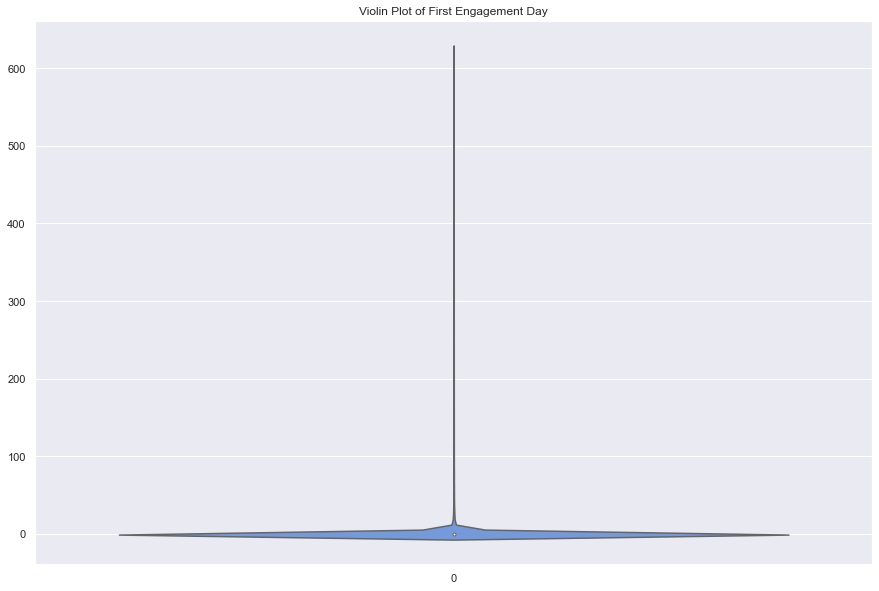

In [14]:
sns.violinplot(post_first_engagement['engage_min_day'], color = 'cornflowerblue')
plt.title('Violin Plot of First Engagement Day')

Majority of the question posts received their first comment or answer within a day or less a week. The median is closer to 0. This indicates a user can expect to received a comment or an answer with a few days or less after posting a question on the Stackoverflow platform.

Let take a look at MoM engagement rate.

In [73]:
# extract month for grouping
post_first_engagement['month'] = post_first_engagement['question_creation_date'].dt.month

In [87]:
# filter out post without first engagement day, group by the month of question creation date and count questions received an answer/comment within 1 day. 
engagement_mom = post_first_engagement[(post_first_engagement['engage_min_day'].isin([1,0]))].groupby('month')['question_id'].size().rename('under_volume').reset_index()
# monthly total questions posted.
engagement_mom['total'] = post_first_engagement.groupby('month')['question_id'].size().rename('under_volume').reset_index()['under_volume']

In [92]:
# calculate percentage
engagement_mom['perc'] = round(engagement_mom['under_volume'] / engagement_mom['total'] * 100,2)
engagement_mom

,month,under_volume,total,perc
0,1,22884,24979,91.61
1,2,21421,23345,91.76
2,3,23848,26201,91.02
3,4,22555,24773,91.05
4,5,22327,24365,91.64
5,6,20748,22591,91.84
6,7,20336,22305,91.17
7,8,19656,21473,91.54
8,9,18974,21234,89.36
9,10,20466,24414,83.83


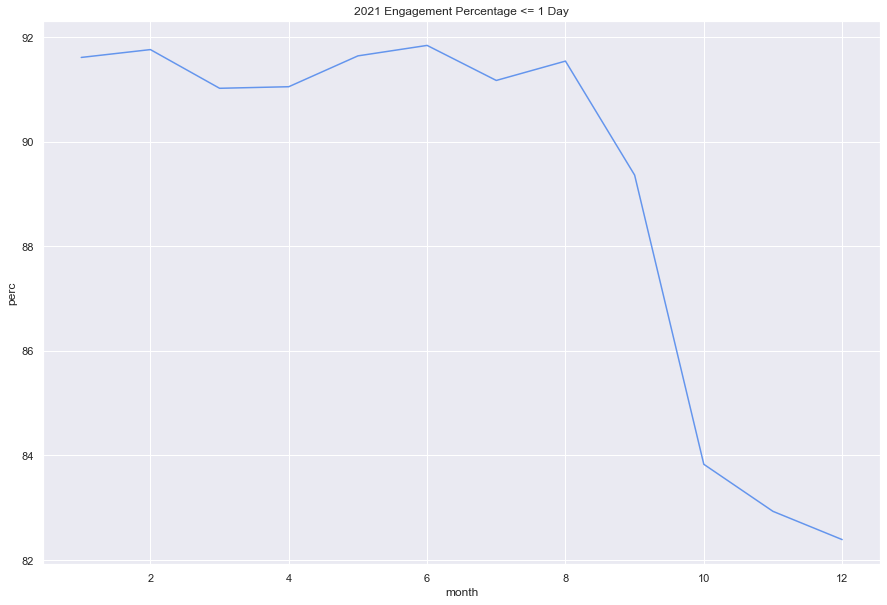

In [319]:
sns.set(rc={'figure.figsize':(15,10)})
sns.lineplot(data = engagement_mom, x = 'month', y = 'perc', color = 'cornflowerblue')
plt.title('2021 Engagement Percentage <= 1 Day')

Approximately 80% or more of the posts each month receive engagement from the community within 1 day. This is an excellent for measuring community engagement. However, from September to December, there has been a declining trend, with the engagement rate dropping from the high 90s to the low 80s. The holiday season is a likely contributing factor to this decrease, as there are several public holidays in this quarter and people are generally less available. It would be intriguing to determine which regions are affected by this trend.

Moving on, let take a look at if number of views has any effect on answer or comments count

In [4]:
query = '''
    SELECT 
        id,
        answer_count,
        comment_count,
        view_count
    FROM `bigquery-public-data.stackoverflow.posts_questions`
    WHERE 
        extract(year from creation_date) = 2021
        and tags like '%python%'
        
'''

engagement_count = get_query_as_df(query)
engagement_count.head()

,id,answer_count,comment_count,view_count
0,70461095,5,0,1281
1,70413959,5,0,266
2,70435468,5,0,274
3,70527241,5,0,296
4,70413045,5,0,43


In [5]:
engagement_count.isnull().any()

id               False
answer_count     False
comment_count    False
view_count       False
dtype: bool

Text(0.5, 0.98, 'Views vs Answer/Comment')

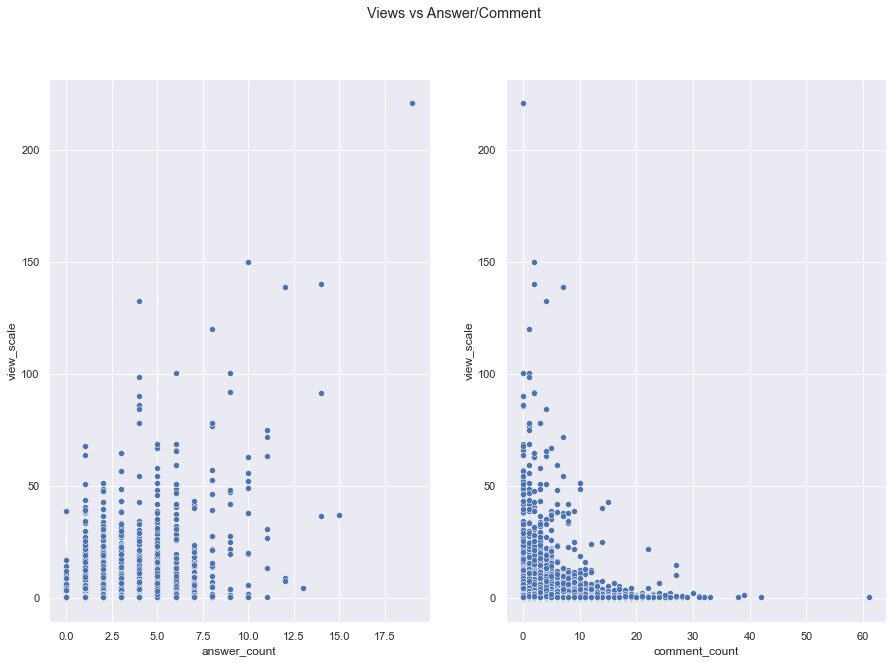

In [10]:
sns.set(rc={'figure.figsize':(15,10)})
fig,ax = plt.subplots(1,2)
sns.scatterplot(data=engagement_count, x='answer_count', y = 'view_count', ax=ax[0])
sns.scatterplot(data=engagement_count, x='comment_count', y = 'view_count', ax=ax[1])
fig.suptitle('Views vs Answer/Comment')

There is a slight relationship with number of view and answer. It makes sense for a question post to receives more answers with more viewers. Or a question might receives more answers if it does not have an accepted answer. However, there is a negative relationship between views and comments. Question posts with high views get lower comments. Low views and high comments count might be due to a number of factors: insufficient context, fail to follow community guideline, duplicated questions, etc... Moderators or the community is most likely to post a comment suggestign modification or provide link to other resources. On the other hand, a question post has a high view count and a low comment count might be due to the fact that it contains accepted answers that the views are looking for. 

I would like to do a deep dive more into this segment to understand users' engagement on the platform. But it is outside of the original objectives for this exercise. Maybe in another project. Let move on and take a dive into Month Active Users data.

In [98]:
# review table schema
schema = get_table_schema('bigquery-public-data.stackoverflow.users')
schema

[SchemaField('id', 'INTEGER', 'NULLABLE', None, None, (), None),
 SchemaField('display_name', 'STRING', 'NULLABLE', None, None, (), None),
 SchemaField('about_me', 'STRING', 'NULLABLE', None, None, (), None),
 SchemaField('age', 'STRING', 'NULLABLE', None, None, (), None),
 SchemaField('creation_date', 'TIMESTAMP', 'NULLABLE', None, None, (), None),
 SchemaField('last_access_date', 'TIMESTAMP', 'NULLABLE', None, None, (), None),
 SchemaField('location', 'STRING', 'NULLABLE', None, None, (), None),
 SchemaField('reputation', 'INTEGER', 'NULLABLE', None, None, (), None),
 SchemaField('up_votes', 'INTEGER', 'NULLABLE', None, None, (), None),
 SchemaField('down_votes', 'INTEGER', 'NULLABLE', None, None, (), None),
 SchemaField('views', 'INTEGER', 'NULLABLE', None, None, (), None),
 SchemaField('profile_image_url', 'STRING', 'NULLABLE', None, None, (), None),
 SchemaField('website_url', 'STRING', 'NULLABLE', None, None, (), None)]

In [104]:
# MAU for engagement: number of user create a comment, post question or answer per month within the python community
# some post with null user id, not sure what going on there

query = '''
   WITH questions as (
        SELECT 
            id,
            creation_date,
            owner_user_id,
            "q" as p_type
        FROM `bigquery-public-data.stackoverflow.posts_questions`
        WHERE 
            extract(year from creation_date) = 2021
            and tags like '%python%'
            and owner_user_id is not null
    ),
    answers as (
         SELECT
            id,
            creation_date,
            owner_user_id,
            "a" as p_type
        FROM
            `bigquery-public-data.stackoverflow.posts_answers`
        WHERE
            parent_id in (SELECT distinct id FROM questions)
            and owner_user_id is not null
    ),
    comments as (
        SELECT
            id,
            creation_date,
            user_id,
            'c' as p_type
        FROM
            `bigquery-public-data.stackoverflow.comments`
        WHERE
            (post_id in (SELECT distinct id FROM answers) or post_id in (SELECT distinct id FROM questions))
            and user_id is not null
    )
    
    SELECT * FROM questions
    
    UNION ALL
    
    SELECT * FROM answers
        
    UNION ALL
    
    SELECT * FROM comments
'''

users_mau = get_query_as_df(query)
users_mau.sample(10)

,id,creation_date,owner_user_id,p_type
1038658,119316920,2021-05-12 14:07:46.960000+00:00,13332582,c
342909,68742403,2021-08-11 12:51:20.210000+00:00,16637979,a
143661,69227321,2021-09-17 17:19:14.753000+00:00,8520715,q
955847,123233125,2021-10-26 06:24:53.443000+00:00,2901002,c
1199968,118985433,2021-04-29 11:09:32.760000+00:00,11516012,c
422651,65544392,2021-01-02 21:41:38.970000+00:00,11739353,a
1155331,120936870,2021-07-18 15:10:43+00:00,15914159,c
456746,66187464,2021-02-13 16:40:01.750000+00:00,1832058,a
646793,118077156,2021-03-25 10:37:49.587000+00:00,2901002,c
87256,69352036,2021-09-27 19:05:33.987000+00:00,12217822,q


In [105]:
# MAU, any one with an activity within the given month
users_mau['month'] = users_mau['creation_date'].dt.month
users_mau.head()

,id,creation_date,owner_user_id,p_type,month
0,67604804,2021-05-19 14:03:50.990000+00:00,7253916,q,5
1,67638561,2021-05-21 14:11:47.480000+00:00,15982783,q,5
2,67655384,2021-05-23 01:19:59.850000+00:00,14231865,q,5
3,67669234,2021-05-24 08:56:54.430000+00:00,7665001,q,5
4,67820871,2021-06-03 11:45:07.313000+00:00,14639019,q,6


Text(0.5, 1.0, 'MAU')

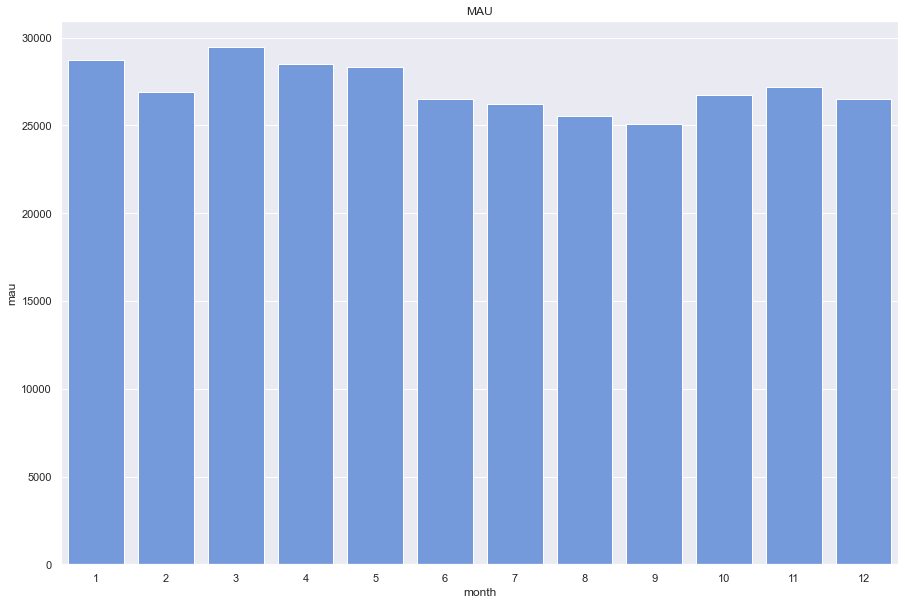

In [337]:
mom_mau = users_mau.groupby('month')['owner_user_id'].nunique().rename('mau').reset_index()

sns.set(rc={'figure.figsize':(15,10)})
sns.barplot(data = mom_mau.sort_values('month'),x = 'month', y = 'mau', color = 'cornflowerblue')
plt.title('MAU')

Within the Python community, there are 25k+ MAU for any given month that posted a question, comment, or an answer. At a glance, the MAU rate remains relatively consistent within 25k - 30k range. 

Let look the relationship between each of the users attribute(tenure, number of posts created, up votes, down votes, views received, reputation).

In [4]:
query = '''
WITH questions AS (
    SELECT
        id,
        creation_date,
        owner_user_id,
        'q' AS p_type
    FROM
        bigquery-public-data.stackoverflow.posts_questions
    WHERE
        extract(year from creation_date) = 2021
        AND tags LIKE '%python%'
        AND owner_user_id IS NOT NULL
),
answers AS (
    SELECT
        id,
        creation_date,
        owner_user_id,
        'a' AS p_type
    FROM
        bigquery-public-data.stackoverflow.posts_answers
    WHERE
        parent_id IN (SELECT id FROM questions)
        AND owner_user_id IS NOT NULL
),
comments AS (
    SELECT
        id,
        creation_date,
        user_id AS owner_user_id,
        'c' AS p_type
    FROM
        bigquery-public-data.stackoverflow.comments
    WHERE
        (post_id IN (SELECT id FROM questions) OR post_id IN (SELECT id FROM answers))
        AND user_id IS NOT NULL
),
posts AS (
    SELECT
        owner_user_id,
        id,
        creation_date
    FROM
        questions
    
    UNION ALL
    
    SELECT
        owner_user_id,
        id,
        creation_date
    FROM
        answers
    
    UNION ALL
    
    SELECT
        owner_user_id,
        id,
        creation_date
    FROM
        comments
)

SELECT
    distinct u.id,
    u.creation_date,
    u.reputation,
    u.up_votes,
    u.down_votes,
    u.views,
    MAX(p.creation_date) AS last_engagement_date,
    COUNT(DISTINCT p.id) AS num_posts
FROM
    bigquery-public-data.stackoverflow.users AS u
    JOIN posts AS p ON u.id = p.owner_user_id
GROUP BY 
    u.id,
    u.creation_date,
    u.reputation,
    u.up_votes,
    u.down_votes,
    u.views
HAVING
    num_posts IS NOT NULL;
'''

users_info = get_query_as_df(query)
users_info.sample(10)

,id,creation_date,reputation,up_votes,down_votes,views,last_engagement_date,num_posts
25412,3890904,2014-07-30 09:38:20.367000+00:00,303,26,0,232,2021-12-17 05:01:33.213000+00:00,5
91737,15044803,2021-01-20 12:55:40.090000+00:00,21,0,0,1,2021-01-20 13:08:09.057000+00:00,1
48011,11678336,2019-06-20 21:30:18.273000+00:00,86,13,0,37,2021-07-04 13:57:28.490000+00:00,4
82636,17076757,2021-10-05 05:17:34.820000+00:00,3,0,0,1,2021-10-05 05:47:11.500000+00:00,1
113054,17195791,2021-10-19 20:43:18.540000+00:00,23,0,0,2,2021-10-19 22:27:00.413000+00:00,2
66057,12746407,2020-01-20 08:04:58.670000+00:00,1,0,0,0,2021-05-03 17:25:48.207000+00:00,2
31468,6743695,2016-08-22 12:57:12.873000+00:00,65,1,0,38,2021-07-19 22:03:49.713000+00:00,5
9645,364966,2010-06-11 22:17:02.427000+00:00,4334,409,1,496,2021-06-02 15:58:56.300000+00:00,1
54961,15797352,2021-04-29 23:54:55.757000+00:00,13,0,0,0,2021-04-30 00:30:59.473000+00:00,2
49785,7594967,2017-02-20 19:48:30.427000+00:00,424,28,1,47,2021-05-17 19:28:27.210000+00:00,4


In [5]:
# quick data check on last engagement date vs acct creation date. 
users_info.loc[users_info['last_engagement_date'] < users_info['creation_date']]

,id,creation_date,reputation,up_votes,down_votes,views,last_engagement_date,num_posts
42458,17450994,2021-11-18 20:12:17.750000+00:00,2435,362,11,287,2021-01-06 04:25:23.937000+00:00,3
58146,15769933,2021-04-26 16:44:46.130000+00:00,26,0,0,0,2021-04-26 16:00:05.037000+00:00,1
65674,18198583,2022-02-13 21:27:00.947000+00:00,1,0,0,0,2021-10-18 01:29:18.590000+00:00,1
67065,15957705,2021-05-18 05:23:55.990000+00:00,1,0,0,1,2021-03-08 07:26:41.623000+00:00,1
71595,17706714,2021-12-18 05:35:39.407000+00:00,1,0,0,1,2021-06-18 04:08:46.543000+00:00,1
75976,17440552,2021-11-17 17:09:25.193000+00:00,3,0,0,1,2021-11-17 16:02:27.987000+00:00,1
104429,16649196,2021-08-12 10:29:36.423000+00:00,3,0,0,2,2021-08-02 12:08:23.120000+00:00,1
194979,15352666,2021-03-08 09:36:32.853000+00:00,111,0,0,19,2021-03-08 07:13:40.417000+00:00,1


Looks like there are users with incorrect recorded dates: last engagement dates are before the account creation dates. There is a user with id 65674 with creation date in 2022 and last engagement date in 2021. We will be removing these users as it is highly unlikely a user can engage(create question, answer or comment) on the platform without creating an account first. 

Feature Engineering: calculating tenure days
- Adding user tenure in number of days starting from the account creation date to the last date when the user created a post.

In [14]:
users_data = users_info

users_data.loc[user_data['last_engagement_date'] > user_data['creation_date'], 'tenure_days'] = (user_data['last_engagement_date'] - user_data['creation_date']).dt.days

Text(0.5, 1.0, 'User Attributes Matrix')

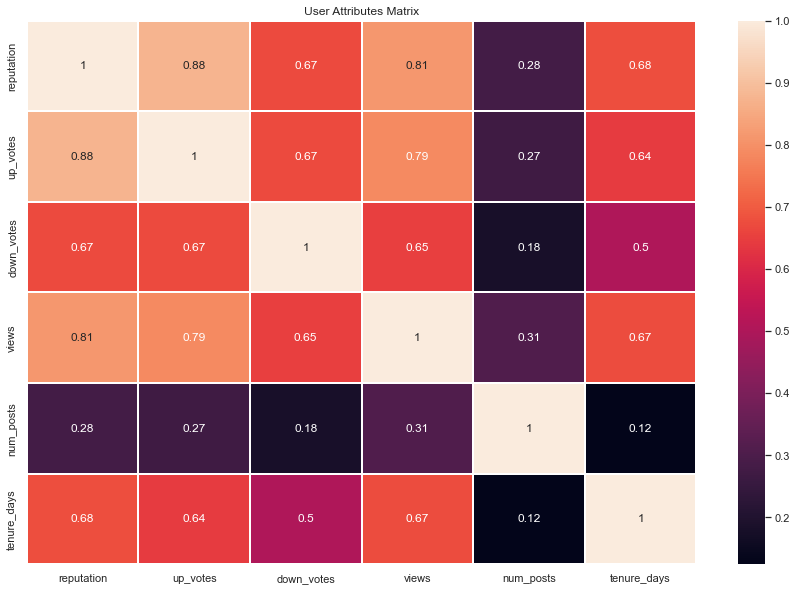

In [16]:
# using spearman default corr method
sns.set(rc={'figure.figsize':(15,10)})
sns.heatmap(data=users_data.drop(['creation_date', 'id', 'last_engagement_date'], axis = 1).corr(method='spearman'),annot=True, linewidth=0.1)
plt.title('User Attributes Matrix')

The heatmap reveals a number of moderate to high correlation relationships, but the correlation coefficient score between number of posts and tenure is surprisingly low. Initially, one might expect that users with longer tenure would have more posts, but this doesn't seem to be the case. It would be interesting to see posts metric between user cohorts.

The highest correlation coefficient score is between upvotes and reputation, which is not surprising as it makes sense that users with more upvotes would have a higher reputation. The scores for the other pairs are also as expected. For future projects, I would like to create a logistic regression model to predict a user's reputation based on these features.

Moving on to the fun part: the Python communities and sub-groups based on question posts and applied tags.

### 3.2 Python Communities Network

For the remainder of this project, I would like to examine different sub-groups and communities within the Python community and determine their "popularity." A sub-group could be a group of Python users specializing in data science/analytics, data engineering, web development, etc. Popularity will be determined by the tags used in question posts. For instance, if a post contains the tags "pandas" and "numpy," their tag pair would have a value of 1. By aggregating the values for these tags and comparing them to other tags and sub-groups, we can measure popularity.

In [161]:
# query request for all question posts and their tags
query = '''
    SELECT 
        distinct id,
        tags
    FROM `bigquery-public-data.stackoverflow.posts_questions`
    WHERE 
        extract(year from creation_date) = 2021
        and tags like '%python%'
'''

questions_tags = get_query_as_df(query)
questions_tags.sample(10)

,id,tags
244452,70031049,python
107331,65631951,python|web-scraping|beautifulsoup
235869,67448376,python|pandas|matplotlib|plot|linechart
104144,69168065,python|docker|go|docker-compose|docker-networking
231266,66718617,python|django|django-models|csvreader
87061,69111997,python|connector|tdengine
62517,68257612,python|selenium|selenium-webdriver
117975,69333111,python|graph|path|depth-first-search
262002,69482498,python|django
150314,69611476,python|pandas|pandas-ta


In [179]:
# splitting tags at '|'
questions_tags['tags_list'] = [tag.split('|') for tag in questions_tags['tags']]

# sorted tags in list and remove any python.* tag, meaning we dont want to measure python relationship to itself. 
questions_tags['tags_list'] = questions_tags['tags_list'].apply(lambda x: sorted([tag for tag in x if 'python' not in tag]))
questions_tags.head()

,id,tags,tags_list
0,70343404,python|binance,[binance]
1,70242780,python|endpoint|web3py|bsc,"[bsc, endpoint, web3py]"
2,70115309,python|web-scraping|beautifulsoup|wikipedia,"[beautifulsoup, web-scraping, wikipedia]"
3,70048281,python|pyopencl,[pyopencl]
4,70373342,python|tensorflow|tensorflow2.0|tensor|ragged-...,"[ragged-tensors, tensor, tensorflow, tensorflo..."


In [354]:
# create relationship array
tags_pair = []

for tags in questions_tags['tags_list']:
    # create different combination pairs
    t_pair = list(itertools.combinations(tags,2))
    # add created pairs to array
    tags_pair += t_pair

# checking if any pair has less than 2 tags
single_pair = [pair for pair in tags_pair if len(pair) < 2]
print('Num of Single Tag Pair: ',len(single_pair))

# count pair values and reorder desc
tags_relationship_value = pd.DataFrame(tags_pair, columns=['source', 'target'])
tags_relationship_value = tags_relationship_value.groupby(['source', 'target']).size().rename('value').reset_index().sort_values('value', ascending=False)

print('tags pair size: ', len(tags_relationship_value))

Num of Single Tag Pair:  0
tags pair size:  143205


There are 143205 tags pairs. To eliminate visual noise and less important pairs, I will be limited to the top 500 highest pair values. 

In [ ]:
# create a network map of each node 
G = nx.from_pandas_edgelist(tags_relationship_value[:500],
                           source = 'source',
                           target = 'target',
                           edge_attr = 'value',
                           create_using = nx.Graph())

# let take a look at the network graph using kamada layout
# plt.figure(figsize=(15,15))
# pos = nx.kamada_kawai_layout(G)
# nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
# plt.show()

In [13]:
# sub for png since html output does not display in markdown file
# Image('../images/tags_network_kamada.png')

In [ ]:
# create degree centrality size
node_degree = dict(G.degree)

#Setting up node size attribute
nx.set_node_attributes(G, node_degree, 'size')

# pretify the graph with increase node size and assign group value so pyvis can create unique color for each central node
communities = community_louvain.best_partition(G)
nx.set_node_attributes(G, communities, 'group')
com_net = Network(notebook = True, width="1500px", height="1000px", bgcolor='#222222', font_color='white')
com_net.from_nx(G)
com_net.show("tags_communities.html")

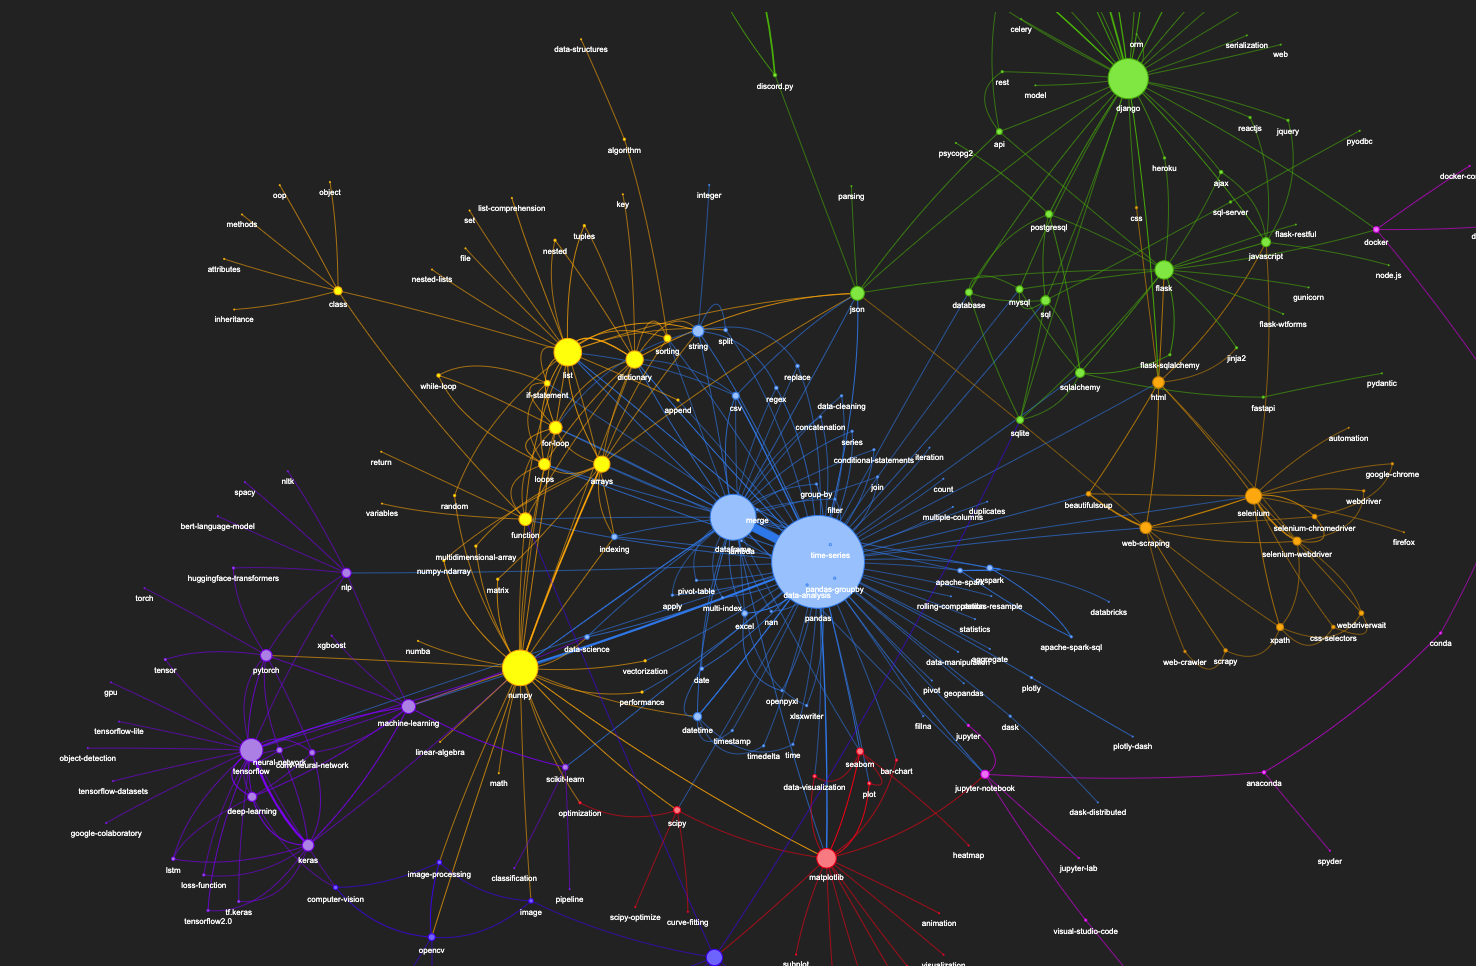

In [335]:
# sub for png since html output does not display in markdown file
Image(filename='../images/tags_network.png')

From the graph, we can see that the Pandas community is most popular among question posts. However, the next biggest group is DataFrame which is misleading as DataFrame is a member of Pandas module. Maybe that is why they both have the same color. While Pandas has many use cases and applications, it is a must have package for all data scientists/analysts. This idea is reinforce by Numpy, Jupyter Notebook and Matplotlib nodes.

That said, the next 2 biggest Python communities are web developers(green) and ML engineers(purple). Selenium/webscraping(orange) sub-group is a bit ambigous. It can belong to both data specialization for scraping web data or can be use for test cases as Selenium is known for. Hard to determine since it is connected to both Pandas and django nodes.

## 4.0 Conclusion

### Recap

Data from 2021 indicates the highest engagement days and months. The analysis shows that users have approx. 92% chance, at peak, to 82% probability of getting a comment or response within 24 hours of posting a question. This is beneficial for the Python community. However, the number of views a question receives does not guarantee more comments or answers, as questions with less views may receive more comments. Moreover, user tenure and number of posts are not accurate indicators of reputation, but views, upvotes, and downvotes have strong correlation to a user's reputation. Further analysis through linear regression modeling may reveal a more accurate predictor of a user's reputation.

Python is widely used in the software development community, with data science/analysts being the largest group, according to network analysis. It would be interesting to determine if this trend has been consistent historically prior to 2021 and if it will continue in the future.

### Further Analysis

If available, I would like to explore users' occupation to gain a better understanding of their demographics. The charts above sare showing downward trend in the number of question posts created during weekday and non-summer session months. To improve engagement during these periods, it would be beneficial to identify which user segments are most engaged and target efforts to increase their engagement.

In addition, users who post more comments and answers than questions may be a high-engagement segment worth focusing on to increase overall platform traffic. It's worth noting that users are often able to easily locate answers on Stack Overflow through Google search, making it a popular resource for developers and other tech professionals.

# 5.0 Appendix A

## 5.1 Resources

- Google BQ public dataset [documentation](https://cloud.google.com/blog/topics/public-datasets/google-bigquery-public-datasets-now-include-stack-overflow-q-a) for Stackoverflow.
- Google [BigQuery API Client Libraries](https://cloud.google.com/bigquery/docs/reference/libraries).
- [Pyvis](https://pyvis.readthedocs.io/en/latest/tutorial.html) and [NetworkX](https://networkx.org/documentation/stable/tutorial.html) tutorials
- Thu Vu's [The Witcher Network](https://github.com/thu-vu92/the_witcher_network)